In [3]:
import pandas as pd
import numpy as np
import seaborn as sn
from keras.models import Sequential
from keras.layers import Dense,SimpleRNN, Conv1D, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## 4. CNN *vs* RNN Prediciendo el Ozono Atmosférico

**a)**

In [4]:
data = pd.read_csv('./ozone_data.csv') 
data_train, data_val, data_test = np.split(data.sample(frac=1), [int(.6*len(data)), int(.8*len(data))])

In [5]:
data_train_o3= data_train[["registered_on","O3"]].sort_index()
data_val_o3= data_val[["registered_on", "O3"]].sort_index()
data_test_o3= data_test[["registered_on","O3"]].sort_index()

In [6]:
X_train = data_train.values[:,1:]
X_test = data_test_o3.values[:,1:]
X_val = data_val_o3.values[:,1:]

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
scaler.fit(X_val)
X_val_scaled = scaler.transform(X_val)
scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)

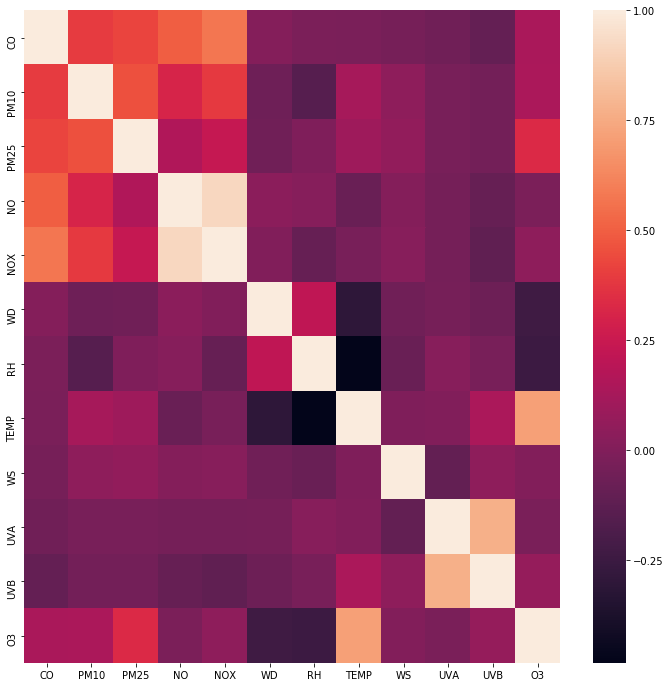

In [7]:
plt.subplots(figsize = (12,12))
sn.heatmap(data.corr())

**b)**

In [8]:
def create_dataset(dataset,lag=1):
    dataX = []
    dataY = []
    dataset = dataset.flatten()
    for i in range(lag+1, len(dataset)):
        dataX.append(dataset[i-(lag+1):i-1])
        dataY.append(dataset[i])
    return np.array(dataX),np.array(dataY)

In [9]:
lag = 3
trainX, trainY = create_dataset(X_train_scaled, lag)
testX, testY = create_dataset(X_test_scaled, lag)
valX, valY = create_dataset(X_val_scaled, lag)

**c)**

In [10]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
#valX = np.reshape(valX, (valX.shape[0], 1, valX.shape[1]))

In [11]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=4, input_shape=(1,lag), activation='tanh',return_sequences=False,go_backwards=False))
model_rnn.add(Dense(1,activation='linear'))
model_rnn.compile(loss='mean_squared_error', optimizer='adam')
model_rnn.summary()
rnn_weights = model_rnn.get_weights()
model_rnn.fit(trainX, trainY, epochs=25, batch_size=1, verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 4)                 32        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Epoch 1/25
11720/11720 [==============================] - 16s 1ms/step - loss: 0.9875
Epoch 2/25
11720/11720 [==============================] - 13s 1ms/step - loss: 0.9801
Epoch 3/25
11720/11720 [==============================] - 12s 1ms/step - loss: 0.9793
Epoch 4/25
11720/11720 [==============================] - 12s 1ms/step - loss: 0.9761
Epoch 5/25
11720/11720 [==============================] - 14s 1ms/step - loss:

In [12]:
model_cnn = Sequential()
model_cnn.add(Conv1D(4, 1,input_shape=(1,lag), activation='relu',padding='valid')) 
model_cnn.add(Flatten())
model_cnn.add(Dense(1,activation='linear'))
model_cnn.compile(loss='mean_squared_error', optimizer='adam')
model_cnn.summary()
cnn_weights = model_cnn.get_weights()
model_cnn.fit(trainX, trainY, epochs=25, batch_size=1, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1, 4)              16        
_________________________________________________________________
flatten_1 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
11720/11720 [==============================] - 13s 1ms/step - loss: 1.0060
Epoch 2/25
11720/11720 [==============================] - 11s 916us/step - loss: 0.9900
Epoch 3/25
11720/11720 [==============================] - 11s 913us/step - loss: 0.9877
Epoch 4/25
11720/11720 [==============================] - 12s 996us/step - loss: 0.9855
Epoch 5/25
11720/11720 [==============================] - 13

**d)**

In [15]:
## RNN
trainP_RNN = model_rnn.predict(trainX,batch_size=1)
trainPredict_RNN = scaler.inverse_transform(trainP_RNN)
trainYre_RNN = trainY.reshape(-1,1)
trainYre_RNN = scaler.inverse_transform(trainYre_RNN)

testP_RNN = model_rnn.predict(testX,batch_size=1)
testPredict_RNN = scaler.inverse_transform(testP_RNN)
testYre_RNN = testY.reshape(-1,1)
testYre_RNN = scaler.inverse_transform(testYre_RNN)

# calculate root mean squared error
trainScore_RNN = np.sqrt(mean_squared_error(trainYre_RNN, trainPredict_RNN))
print('Train Score: %.2f RMSE' % (trainScore_RNN))
testScore_RNN = np.sqrt(mean_squared_error(testYre_RNN, testPredict_RNN))
print('Test Score: %.2f RMSE' % (testScore_RNN))

Train Score: 0.13 RMSE
Test Score: 0.13 RMSE


In [16]:
# CNN
trainP_CNN = model_cnn.predict(trainX,batch_size=1)
trainPredict_CNN = scaler.inverse_transform(trainP_CNN)
trainYre_CNN = trainY.reshape(-1,1)
trainYre_CNN = scaler.inverse_transform(trainYre_CNN)

testP_CNN = model_cnn.predict(testX,batch_size=1)
testPredict_CNN = scaler.inverse_transform(testP_CNN)
testYre_CNN = testY.reshape(-1,1)
testYre_CNN = scaler.inverse_transform(testYre_CNN)

# calculate root mean squared error
trainScore_CNN = np.sqrt(mean_squared_error(trainYre_CNN, trainYre_CNN))
print('Train Score: %.2f RMSE' % (trainScore_CNN))
testScore_CNN = np.sqrt(mean_squared_error(testYre_CNN, testYre_CNN))
print('Test Score: %.2f RMSE' % (testScore_CNN))

Train Score: 0.00 RMSE
Test Score: 0.00 RMSE


**e)**

In [17]:
# shift train predictions for plotting
trainPredictPlot = trainPredict_CNN.flatten()
# shift test predictions for plotting
testPredictPlot = testPredict_CNN.flatten()

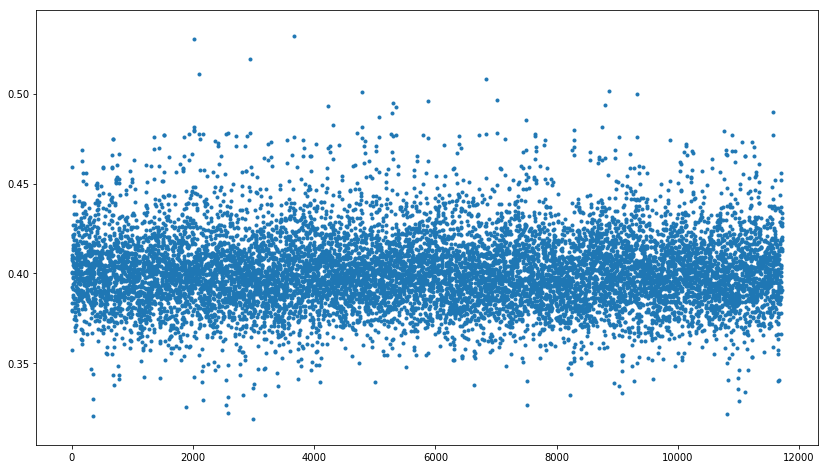

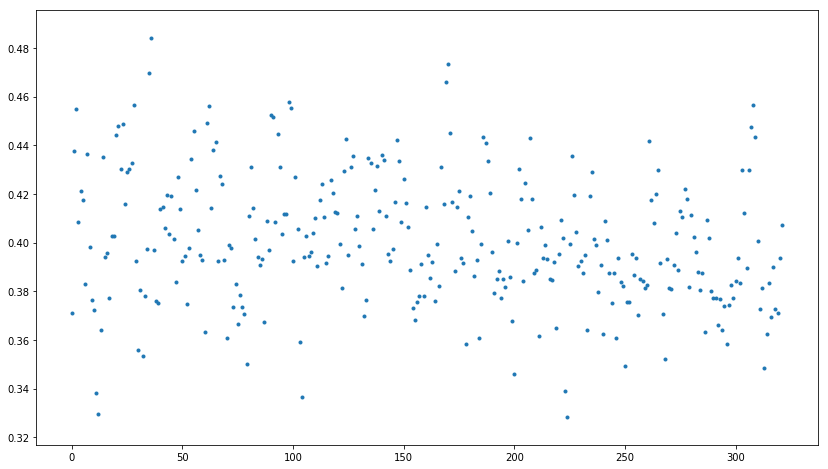

In [45]:
# shift train predictions for plotting
trainPredictPlot_RNN = trainPredict_RNN.flatten()
# shift test predictions for plotting
testPredictPlot_RNN = testPredict_RNN.flatten()

X = range(trainPredictPlot_RNN.shape[0])
plt.figure(1, figsize=(14,8))
plt.scatter(X, trainPredictPlot_RNN, marker=".", label = "Train predict")

#plt.scatter(X, dataframe.values.flatten()[:len(data_train)], marker=".", label= "Original")
#plt.title("Predicciones vs Original en entrenamiento")
#plt.legend();

X = range(testPredictPlot_RNN.shape[0])
plt.figure(2, figsize=(14,8))
plt.scatter(X, testPredictPlot_RNN, marker=".", label = "Test predict")
#plt.scatter(X, dataframe.values.flatten()[len(data_train):len(data_train)+len(data_test)], marker=".", label= "Original")
#plt.title("Predicciones vs Original en testing")
#plt.legend();


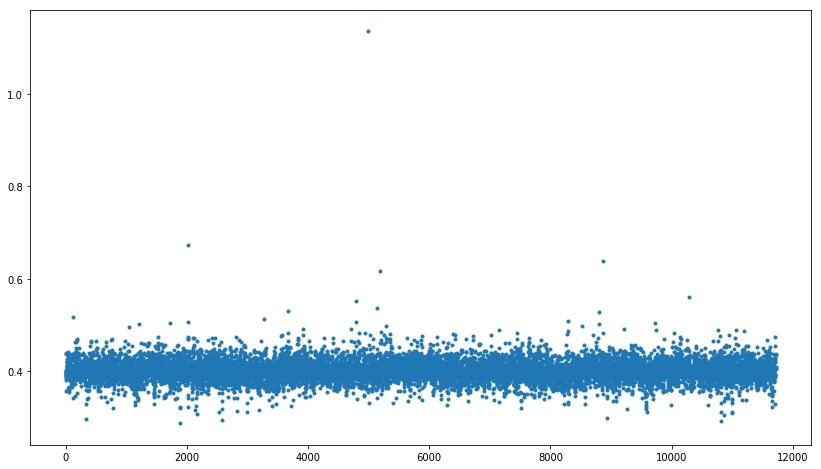

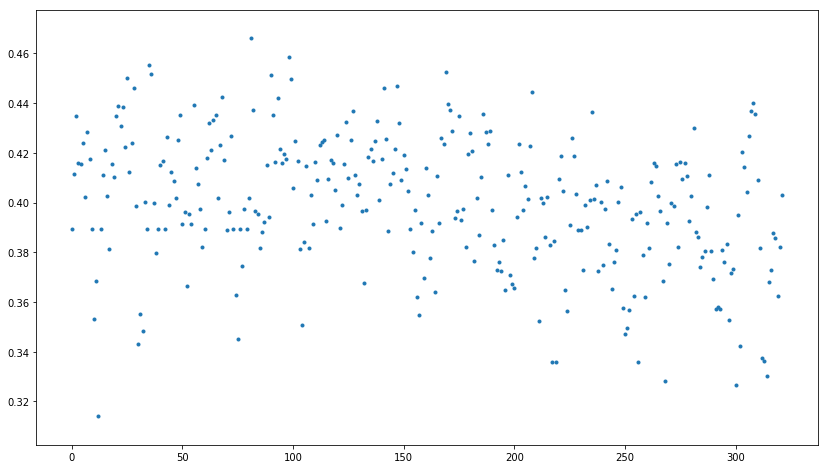

In [44]:
# shift train predictions for plotting
trainPredictPlot_CNN = trainPredict_CNN.flatten()
# shift test predictions for plotting
testPredictPlot_CNN = testPredict_CNN.flatten()

X = range(trainPredictPlot_CNN.shape[0])
plt.figure(1, figsize=(14,8))
plt.scatter(X, trainPredictPlot_CNN, marker=".", label = "Train predict")

#plt.scatter(X, dataframe.values.flatten()[:len(data_train)], marker=".", label= "Original")
#plt.title("Predicciones vs Original en entrenamiento")
#plt.legend();

X = range(testPredictPlot_CNN.shape[0])
plt.figure(2, figsize=(14,8))
plt.scatter(X, testPredictPlot_CNN, marker=".", label = "Test predict")
#plt.scatter(X, dataframe.values.flatten()[len(data_train):len(data_train)+len(data_test)], marker=".", label= "Original")
#plt.title("Predicciones vs Original en testing")
#plt.legend();


**f)**

**g)**

**h)**

**k)**

**i)**